In [1]:
# Generic ones
import numpy as np
import pandas as pd
import os

# Word processing libraries
import re
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Widen the size of each cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import glob
import gzip

# dfs=[]
data = None
total_count=0
keywords_str='#chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu'
print('filtering by:', keywords_str)

for file in glob.glob("E:\\Projects\\twitter_covid\\2020-02\\*.gz"):
#     print(file)
    df = pd.read_json(path_or_buf=file, lines=True, compression='infer')
#     print('Read. Size: ', df.shape)
    
    total_count+=df.shape[0]
    df = df[df['full_text'].str.contains("(?i)"+keywords_str)]
    df.reset_index(inplace = True, drop = True)
    if data is None:
        data = df
    else:
        data = pd.concat([data, df], axis = 0)
        # Reset_index
        data.reset_index(inplace = True, drop = True)
        
data_orig=data.copy()

print('Size of dataset before filtering:', total_count)
print('Size of dataset after filtering:', data.shape[0])



filtering by: #chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu
Size of dataset before filtering: 3523064
Size of dataset after filtering: 5037


In [3]:
data['hashtags'] = data['entities'].apply(lambda x: x['hashtags'])
data['hashtags'].head(3)

0    [{'text': 'ChinaVirus', 'indices': [81, 92]}, ...
1    [{'text': 'stock', 'indices': [40, 46]}, {'tex...
2    [{'text': 'China', 'indices': [19, 25]}, {'tex...
Name: hashtags, dtype: object

In [4]:
# Remove empty tweets
data.dropna(subset = ['full_text'], inplace = True)
# The unicode accounts for Chinese characters and punctuations.
def strip_chinese_words(string):
    # list of english words
    en_list = re.findall(u'[^\u4E00-\u9FA5\u3000-\u303F]', str(string))
    
    # Remove word from the list, if not english
    for c in string:
        if c not in en_list:
            string = string.replace(c, '')
    return string
# Apply strip_chinese_words(...) on the column 'text'
data['full_text'] = data['full_text'].apply(lambda x: strip_chinese_words(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorited,retweeted,possibly_sensitive,lang,extended_entities,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags
0,2020-02-01 14:09:06+00:00,1223609218953072641,1223609218953072640,RT @siasatpk: سنئے چین سے پاکستانی طلباء کا وی...,False,"[0, 112]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,False,False,0.0,ur,NaN,{'created_at': 'Sat Feb 01 13:30:59 +0000 2020...,NaN,NaN,NaN,"[{'text': 'ChinaVirus', 'indices': [81, 92]}, ..."
1,2020-02-01 14:09:08+00:00,1223609230005088256,1223609230005088256,Take a look at my day dealing with this #stock...,False,"[0, 146]","{'hashtags': [{'text': 'stock', 'indices': [40...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,False,False,0.0,en,"{'media': [{'id': 1223609216876916737, 'id_str...",NaN,NaN,NaN,NaN,"[{'text': 'stock', 'indices': [40, 46]}, {'tex..."
2,2020-02-01 14:10:02+00:00,1223609454052237313,1223609454052237312,RT @Finanzas_Time: #China 🇨🇳\n\nInfectado por ...,False,"[0, 140]","{'hashtags': [{'text': 'China', 'indices': [19...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,False,False,NaN,es,NaN,{'created_at': 'Sat Feb 01 09:46:08 +0000 2020...,NaN,NaN,NaN,"[{'text': 'China', 'indices': [19, 25]}, {'tex..."
3,2020-02-01 14:10:16+00:00,1223609514831892485,1223609514831892480,ES DOLOROSO LO QUE ESTÁN PADECIENDO AL OTRO LA...,False,"[0, 217]","{'hashtags': [{'text': 'ChinaPneumonia', 'indi...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,False,False,0.0,es,"{'media': [{'id': 1223604353816199168, 'id_str...",NaN,NaN,NaN,NaN,"[{'text': 'ChinaPneumonia', 'indices': [72, 87..."
4,2020-02-01 14:10:37+00:00,1223609601204973569,1223609601204973568,RT @Shekki6: An innocent baby infected with #c...,False,"[0, 92]","{'hashtags': [{'text': 'coronavirus', 'indices...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,False,False,0.0,en,"{'media': [{'id': 1223227185336606727, 'id_str...",{'created_at': 'Fri Jan 31 12:51:33 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [44, 56]},..."


In [5]:
# Define function to sieve out @users in a tweet:
def mentioned_users(string):
    usernames = re.findall('@[^\s]+', string)
    return usernames
# Create a new column and apply the function on the column 'text'
data['mentioned_users'] = data['full_text'].apply(lambda x: mentioned_users(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweeted,possibly_sensitive,lang,extended_entities,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags,mentioned_users
0,2020-02-01 14:09:06+00:00,1223609218953072641,1223609218953072640,RT @siasatpk: سنئے چین سے پاکستانی طلباء کا وی...,False,"[0, 112]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,False,0.0,ur,NaN,{'created_at': 'Sat Feb 01 13:30:59 +0000 2020...,NaN,NaN,NaN,"[{'text': 'ChinaVirus', 'indices': [81, 92]}, ...",[@siasatpk:]
1,2020-02-01 14:09:08+00:00,1223609230005088256,1223609230005088256,Take a look at my day dealing with this #stock...,False,"[0, 146]","{'hashtags': [{'text': 'stock', 'indices': [40...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,False,0.0,en,"{'media': [{'id': 1223609216876916737, 'id_str...",NaN,NaN,NaN,NaN,"[{'text': 'stock', 'indices': [40, 46]}, {'tex...",[]
2,2020-02-01 14:10:02+00:00,1223609454052237313,1223609454052237312,RT @Finanzas_Time: #China 🇨🇳\n\nInfectado por ...,False,"[0, 140]","{'hashtags': [{'text': 'China', 'indices': [19...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,False,NaN,es,NaN,{'created_at': 'Sat Feb 01 09:46:08 +0000 2020...,NaN,NaN,NaN,"[{'text': 'China', 'indices': [19, 25]}, {'tex...",[@Finanzas_Time:]
3,2020-02-01 14:10:16+00:00,1223609514831892485,1223609514831892480,ES DOLOROSO LO QUE ESTÁN PADECIENDO AL OTRO LA...,False,"[0, 217]","{'hashtags': [{'text': 'ChinaPneumonia', 'indi...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,False,0.0,es,"{'media': [{'id': 1223604353816199168, 'id_str...",NaN,NaN,NaN,NaN,"[{'text': 'ChinaPneumonia', 'indices': [72, 87...",[]
4,2020-02-01 14:10:37+00:00,1223609601204973569,1223609601204973568,RT @Shekki6: An innocent baby infected with #c...,False,"[0, 92]","{'hashtags': [{'text': 'coronavirus', 'indices...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,False,0.0,en,"{'media': [{'id': 1223227185336606727, 'id_str...",{'created_at': 'Fri Jan 31 12:51:33 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [44, 56]},...",[@Shekki6:]


In [6]:
# Define Emoji_patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
# Define the function to implement POS tagging:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Define the main function to clean text in various ways:
def clean_text(text):
    
    # Apply regex expressions first before converting string to list of tokens/words:
    # 1. remove @usernames
    text = re.sub('@[^\s]+', '', text)
    
    # 2. remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    
    # 3. remove hashtags entirely i.e. #hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    # 4. remove emojis
    text = emoji_pattern.sub(r'', text)
    
    # 5. Convert text to lowercase
    text = text.lower()
    
    # 6. tokenise text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # 7. remove numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # 8. remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # 9. remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # 10. pos tag text and lemmatize text
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # 11. remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    
    return(text)
# Apply function on the column 'text':
data['cleaned_text'] = data['full_text'].apply(lambda x: clean_text(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,possibly_sensitive,lang,extended_entities,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags,mentioned_users,cleaned_text
0,2020-02-01 14:09:06+00:00,1223609218953072641,1223609218953072640,RT @siasatpk: سنئے چین سے پاکستانی طلباء کا وی...,False,"[0, 112]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,0.0,ur,NaN,{'created_at': 'Sat Feb 01 13:30:59 +0000 2020...,NaN,NaN,NaN,"[{'text': 'ChinaVirus', 'indices': [81, 92]}, ...",[@siasatpk:],rt سنئے چین سے پاکستانی طلباء کا ویڈیو پیغام\n...
1,2020-02-01 14:09:08+00:00,1223609230005088256,1223609230005088256,Take a look at my day dealing with this #stock...,False,"[0, 146]","{'hashtags': [{'text': 'stock', 'indices': [40...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0.0,en,"{'media': [{'id': 1223609216876916737, 'id_str...",NaN,NaN,NaN,NaN,"[{'text': 'stock', 'indices': [40, 46]}, {'tex...",[],take look day deal please don’t laugh nnvc \n\n
2,2020-02-01 14:10:02+00:00,1223609454052237313,1223609454052237312,RT @Finanzas_Time: #China 🇨🇳\n\nInfectado por ...,False,"[0, 140]","{'hashtags': [{'text': 'China', 'indices': [19...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,NaN,es,NaN,{'created_at': 'Sat Feb 01 09:46:08 +0000 2020...,NaN,NaN,NaN,"[{'text': 'China', 'indices': [19, 25]}, {'tex...",[@Finanzas_Time:],rt \n\ninfectado por el en primera persona.\n\...
3,2020-02-01 14:10:16+00:00,1223609514831892485,1223609514831892480,ES DOLOROSO LO QUE ESTÁN PADECIENDO AL OTRO LA...,False,"[0, 217]","{'hashtags': [{'text': 'ChinaPneumonia', 'indi...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,0.0,es,"{'media': [{'id': 1223604353816199168, 'id_str...",NaN,NaN,NaN,NaN,"[{'text': 'ChinaPneumonia', 'indices': [72, 87...",[],doloroso lo que están padeciendo al otro lado ...
4,2020-02-01 14:10:37+00:00,1223609601204973569,1223609601204973568,RT @Shekki6: An innocent baby infected with #c...,False,"[0, 92]","{'hashtags': [{'text': 'coronavirus', 'indices...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0.0,en,"{'media': [{'id': 1223227185336606727, 'id_str...",{'created_at': 'Fri Jan 31 12:51:33 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [44, 56]},...",[@Shekki6:],rt innocent baby infect


In [7]:
# Define a function to perform this extraction:
def extract_hashtags(hashtag_list):
    # argument:
    # hashtag_list - a list of dictionary(ies), each containing a hashtag
    
    # Create a list to store the hashtags
    hashtags = []
    if isinstance(hashtag_list, float):
        hashtag_list=[]
    
    # Loop through the list:
    for i in range(0, len(hashtag_list)):
        # extract the hashtag value using the key - 'text'
        # For our purposes, we can ignore the indices, which tell us the position of the hashtags in the string of tweet
        # lowercase the text as well
        hashtags.append(hashtag_list[i]['text'].lower())
        
    return hashtags
# Apply function on the column - data['hashtags']
data['hashtags'] = data['hashtags'].apply(lambda x: extract_hashtags(x))
# Check out the updated column 'hashtags'
print(data.head()['hashtags'])

0                     [chinavirus, coronavirus, china]
1    [stock, coronarvirus, viruscorona, china, chin...
2    [china, coronavirus, chinavirus, wuhanvirus, w...
3       [chinapneumonia, chinavirus, wuhancoronavirus]
4                            [coronavirus, wuhanvirus]
Name: hashtags, dtype: object


In [8]:
#Show hashtags
        
data[data['hashtags'].apply(lambda x: True if len(x)>0 else False)]['hashtags']

0                        [chinavirus, coronavirus, china]
1       [stock, coronarvirus, viruscorona, china, chin...
2       [china, coronavirus, chinavirus, wuhanvirus, w...
3          [chinapneumonia, chinavirus, wuhancoronavirus]
4                               [coronavirus, wuhanvirus]
                              ...                        
5032    [coronaviruscanada, coronavirus, kungflu, nove...
5033            [covid19, coronavirus, wuhanvirus, china]
5034    [coronavirus, coronaoutbreak, corona, virus, c...
5035                         [wuhanvirus, chinese, china]
5036    [coronavirus, coronaoutbreak, coronavirusoutbr...
Name: hashtags, Length: 5036, dtype: object

In [9]:
data['location'] = df.user.apply(lambda x: x['location'])
data['acctdesc'] = df.user.apply(lambda x: x['description'])
data[['location','acctdesc']].head(3)

,location,acctdesc
0,California,"#Maga Not a globalist, a servant of our Lord J..."
1,,
2,,https://t.co/xjc1DtX5jB


In [10]:
# Replace NaN (empty) values with n.a to indicate that the user did not state his location
# Define a function to handle this:
def remove_nan(text):
    if pd.isnull(text) == True: # entry is NaN
        text = 'n.a'
    else:
        # lowercase text for possible easy handling
        text = text.lower()
        
    return text
# Apply function on column - data['location']
data['location'] = data['location'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['location'])
# Let's take a quick look at the value_counts()
data['location'].value_counts()

0       california
1                 
2                 
3                 
4    united states
Name: location, dtype: object


n.a                       5001
united states               11
                            10
east coast, usa              7
bogotá, d.c., colombia       1
california                   1
worldwide                    1
hong kong                    1
geneva, il                   1
northern california          1
talsi                        1
toronto, ontario             1
Name: location, dtype: int64

In [11]:
# Apply the function already defined above: remove_nan(...)
# Apply function on column - data['acctdesc']
data['acctdesc'] = data['acctdesc'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['acctdesc'])

0    #maga not a globalist, a servant of our lord j...
1                                                     
2                              https://t.co/xjc1dtx5jb
3    we are a daily trending entertainment channel,...
4    come learn w/me on periscope; @elizabethsja. c...
Name: acctdesc, dtype: object


In [12]:
# Importing VADER from NLTK
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Create a sid object called SentimentIntensityAnalyzer()
sid = SentimentIntensityAnalyzer()
# Apply polarity_score method of SentimentIntensityAnalyzer()
data['sentiment'] = data['cleaned_text'].apply(lambda x: sid.polarity_scores(x))
# Keep only the compound scores under the column 'Sentiment'
data = pd.concat([data.drop(['sentiment'], axis = 1), data['sentiment'].apply(pd.Series)], axis = 1)

In [13]:
# New column: number of characters in 'review'
data['numchars'] = data['cleaned_text'].apply(lambda x: len(x))
# New column: number of words in 'review'
data['numwords'] = data['cleaned_text'].apply(lambda x: len(x.split(" ")))
# Check the new columns:
data.tail(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,mentioned_users,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords
5035,2020-02-29 22:00:32+00:00,1233874720765960200,1233874720765960192,RT @vvvickie1: Deadly #WuhanVirus can’t wake t...,False,"[0, 140]","{'hashtags': [{'text': 'WuhanVirus', 'indices'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,[@vvvickie1:],rt deadly can’t wake sang song “without commun...,n.a,n.a,0.0,0.803,0.197,0.4019,69,12
5036,2020-02-29 22:00:10+00:00,1233874630470967296,1233874630470967296,First Aid Only FAE-4007 SmartCompliance Refill...,False,"[0, 254]","{'hashtags': [{'text': 'coronavirus', 'indices...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,...,[],first aid smartcompliance refill hand sanitize...,n.a,n.a,0.0,0.714,0.286,0.4939,63,9


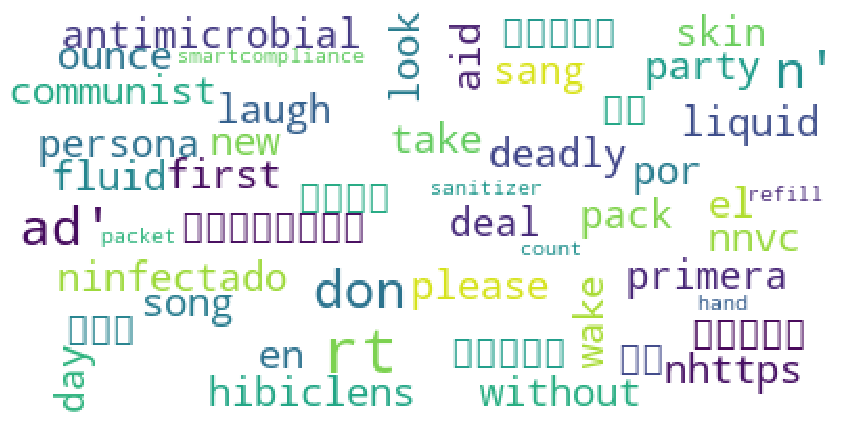

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 400,
        max_font_size = 30, 
        scale = 1,
        random_state = 1
    ).generate(str(data))
    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(data['cleaned_text'].values)

In [15]:
# the column data['hashtags'] returns a list of string(s) for each tweet. Build a list of all hashtags in the dataset.
hashtag_list = []
for i in range(0, len(data)):
    # Obtain the current list of hashtags
    curr_hashtag = data.iloc[i, :]['hashtags']
    
    # Extract and append the hashtags to 'hashtag_list':
    for j in range(0, len(curr_hashtag)):
        hashtag_list.append(curr_hashtag[j])
        
# No. of hashtags
print('No. of hashtags used in {} tweets is {}'.format(len(data), len(hashtag_list)))

df_hashtag = pd.DataFrame(
    {'hashtags': hashtag_list}
)
print(df_hashtag.head(20))
print('Shape of df_hashtag is:', df_hashtag.shape)

No. of hashtags used in 5037 tweets is 24556
            hashtags
0         chinavirus
1        coronavirus
2              china
3              stock
4       coronarvirus
5        viruscorona
6              china
7         chinavirus
8              china
9        coronavirus
10        chinavirus
11        wuhanvirus
12             wuhan
13  wuhancoronavirus
14    chinapneumonia
15        chinavirus
16  wuhancoronavirus
17       coronavirus
18        wuhanvirus
19             china
Shape of df_hashtag is: (24556, 1)


                      hashtags  counts
2058                wuhanvirus    3630
462                coronavirus    2369
327                 chinavirus    1613
292                      china    1282
2019                     wuhan     989
2026          wuhancoronavirus     837
513        coronavirusoutbreak     725
559                    covid19     662
470           coronaviruschina     420
2049            wuhanpneumonia     275
435             coronaoutbreak     224
6                     2019ncov     223
302           chinacoronavirus     222
420                     corona     214
574                  covid2019     191
531           coronaviruswuhan     164
1293                  ncov2019     162
265                   ccpchina     158
1976                       who     154
2046             wuhanoutbreak     153
2255                      武汉肺炎     139
1918                     virus     137
952                   hongkong     127
2027  wuhancoronavirusoutbreak     121
2048             wuhanpne

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27721 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32954 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30123 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24773 missing from c

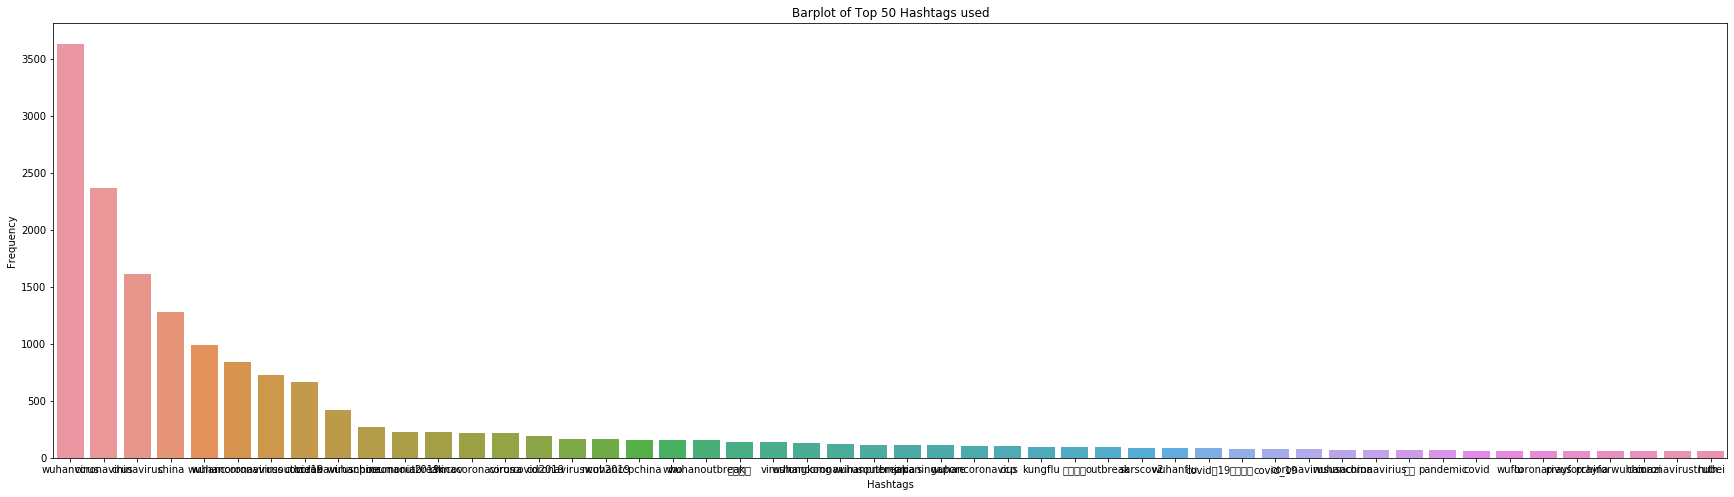

In [16]:
import seaborn as sns

# Define N to be the top number of hashtags
N = 50
top_hashtags = df_hashtag.groupby(['hashtags']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False).head(N)
print(top_hashtags)
# seaborn countplot on the top N hashtags
plt.figure(figsize=(30,8))
sns.set_palette('PuBuGn_d')
sns.barplot(x = 'hashtags', y = 'counts', data = top_hashtags)
plt.title('Barplot of Top ' + str(N) + ' Hashtags used')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.show()

In [30]:
def isNaN(num):
    return num != num

def get_full_name(x):
    if x is None or isNaN(x):
        return None
    else:
        return x['full_name']
data['place_full_name']=data['place'].apply(lambda x: get_full_name(x))

data[data['place_full_name'].apply(lambda x: x is not None)]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
109,2020-02-02 01:15:18+00:00,1223776874209382400,1223776874209382400,#benceCorona Amerika'nın Çin nüfusunu azaltma ...,False,"[0, 80]","{'hashtags': [{'text': 'benceCorona', 'indices...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,amerika'nın çin nüfusunu azaltma çabası,n.a,n.a,0.000,1.000,0.000,0.0000,39,5,"Gaziantep, Türkiye"
142,2020-02-02 01:57:29+00:00,1223787489522933761,1223787489522933760,WUHAN Virus I slap you than you know.. \n\n#wu...,False,"[0, 65]","{'hashtags': [{'text': 'wuhanvirus', 'indices'...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,wuhan virus slap know \n\n,n.a,n.a,0.000,0.652,0.348,0.1531,24,5,"Central Region, Singapore"
283,2020-02-02 08:48:56+00:00,1223891037552164864,1223891037552164864,Just in: India temporarily suspends E-visas fo...,False,"[0, 85]","{'hashtags': [{'text': 'WuhanVirus', 'indices'...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,india temporarily suspend e-visas chinese pass...,n.a,n.a,0.277,0.723,0.000,-0.3182,57,7,"New Delhi, India"
414,2020-02-02 14:17:43+00:00,1223973775495950336,1223973775495950336,Lets all be humane.. God bless all the chinese...,False,"[0, 138]","{'hashtags': [{'text': 'CoronaVirus', 'indices...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,let humane god bless chinese people,n.a,n.a,0.000,0.449,0.551,0.5994,35,6,"Davao City, Davao Region"
434,2020-02-02 14:19:51+00:00,1223974314090749952,1223974314090749952,~ ， 😷 🌼☕️\n: ，，，\n\n# # #WuhanVirus #WuhanPne...,False,"[0, 172]","{'hashtags': [{'text': '抗疫之日常', 'indices': [10...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,\n\n,n.a,n.a,0.000,0.000,0.000,0.0000,2,1,Hong Kong
534,2020-02-02 19:22:43+00:00,1224050531875934208,1224050531875934208,"#China, #coronavirues qurbanlarının cəsədlərin...",False,"[0, 131]","{'hashtags': [{'text': 'China', 'indices': [0,...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,qurbanlarının cəsədlərinin basdırılmasını qada...,n.a,n.a,0.000,1.000,0.000,0.0000,81,8,People's Republic of China
604,2020-02-03 07:57:13+00:00,1224240407912935426,1224240407912935424,Came to do a story about robots helping doctor...,False,"[0, 242]","{'hashtags': [{'text': 'coronavirus', 'indices...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,come story robot help doctor treat cater patie...,n.a,n.a,0.000,0.550,0.450,0.9169,143,22,广东省人民医院 Guangdong General Hospital
890,2020-02-04 06:33:54+00:00,1224581829799354369,1224581829799354368,Been feeling a little hoarse since my recent l...,False,"[0, 233]","{'hashtags': [{'text': 'wuhan', 'indices': [12...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,NaN,...,feel little hoarse since recent long haul flig...,n.a,n.a,0.155,0.845,0.000,-0.2960,98,14,"Amphoe Phatthana Nikhom, Changwat Lop Buri"
1049,2020-02-06 07:57:12+00:00,1225327569400188930,1225327569400188928,[6 Feb 2020] #WHO/#WorldHealthOrganisation = C...,False,"[0, 184]","{'hashtags': [{'text': 'WHO', 'indices': [13, ...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,NaN,...,feb china’s praise china contribution worldwid...,n.a,n.a,0.000,0.660,0.340,0.5574,68,8,"Paddington, London"
1248,2020-02-07 16:34:57+00:00,1225820253180948480,1225820253180948480,Prepared to bring back anyone hailing from nei...,False,"[0, 161]","{'hashtags': [{'text': 'WuhanVirus', 'indices'...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,prepared bring back anyone hailing neighbourho...,n.a,n.a,0.000,0.863,0.137,0.2263,96,13,"New Delhi, India"


In [31]:
data[data['coordinates'].apply(lambda x: x is not None and not isNaN(x))]
# data['coordinates']

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
890,2020-02-04 06:33:54+00:00,1224581829799354369,1224581829799354368,Been feeling a little hoarse since my recent l...,False,"[0, 233]","{'hashtags': [{'text': 'wuhan', 'indices': [12...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,NaN,...,feel little hoarse since recent long haul flig...,n.a,n.a,0.155,0.845,0.00,-0.2960,98,14,"Amphoe Phatthana Nikhom, Changwat Lop Buri"
1049,2020-02-06 07:57:12+00:00,1225327569400188930,1225327569400188928,[6 Feb 2020] #WHO/#WorldHealthOrganisation = C...,False,"[0, 184]","{'hashtags': [{'text': 'WHO', 'indices': [13, ...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,NaN,...,feb china’s praise china contribution worldwid...,n.a,n.a,0.000,0.660,0.34,0.5574,68,8,"Paddington, London"
